In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

In [2]:
df = pd.read_csv('marketing_training.csv')
df_raw_test = pd.read_csv('marketing_test.csv')

# Exploratory Data Analysis (EDA)

In [3]:
### Calculate the null ratio of each feature
def check_null(df):
    count_nan = len(df) - df.count()
    print "The null ratio in PERCENTAGE (%):"
    print (count_nan)/len(df)*100

In [4]:
## Replace all "unknown" with Null values
df.replace('unknown', np.NaN, inplace=True)

## Category features with missing data
missing_category_feature_list = ['profession', 
                                 'marital', 
                                 'schooling',
                                 'default',
                                 'housing',
                                 'loan',
                                 'day_of_week'
                                ]

## Category features without missing data
normal_category_feature_list = ['contact',
                                'month',
                                'poutcome'
                               ]

In [5]:
check_null(df)

The null ratio in PERCENTAGE (%):
custAge           24.332344
profession         0.822768
marital            0.107904
schooling         32.182358
default           19.314810
housing            2.265983
loan               2.265983
contact            0.000000
month              0.000000
day_of_week        9.589965
campaign           0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
pmonths            0.000000
pastEmail          0.000000
responded          0.000000
dtype: float64


## Explore and preprocess missing data in feature "custAge"

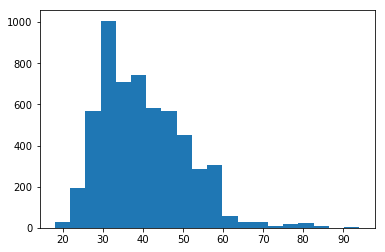

In [6]:
# custAge_not_null = pd.DataFrame(df[pd.notnull(df['custAge'])]['custAge'])
plt.hist(df[pd.notnull(df['custAge'])]['custAge'], bins=20)
plt.show()

In [7]:
# fill missing values with mean column values
custAge_median = df['custAge'].median()
print custAge_median
def custAge_fillna(df):
    df['custAge'].fillna(custAge_median, inplace=True)

38.0


In [8]:
custAge_fillna(df)

## Explore and preprocess missing data in feature "day_of_week"

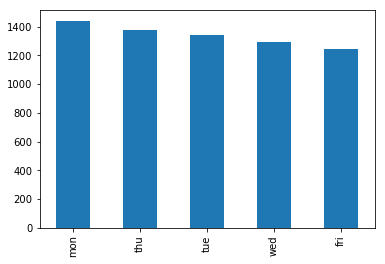

In [9]:
## Keep non-null values, and plot histogram
day_of_week_not_null = pd.DataFrame(df[pd.notnull(df['day_of_week'])]['day_of_week'])
day_of_week_not_null.day_of_week.value_counts().plot(kind='bar')

In [10]:
def fillna_based_on_ratio_dummy_prp(df, feature):
    ## Calculate ratio of each non-null element, which will be used in both training data
    ## and test data
    print '-------------------------------------'
    print feature + '(ratio):'
    print '---------------'
        
    non_null_list = df[pd.notnull(df[feature])][feature]
    non_null_list_unique = non_null_list.unique()
    element_ratio = []
    for item in non_null_list_unique:
        each_ratio = len(non_null_list[non_null_list==item])/float(len(non_null_list))
        element_ratio.append(each_ratio)
        print str(item) + ": " + str(each_ratio)
   
    return non_null_list_unique, element_ratio

In [11]:
def fillna_based_on_ratio_dummy(df, feature, non_null_list_unique, element_ratio): 
    ## Replace the null in feature 'day_of_week' with 'mon' to 'fri' based on respective ratio 
    df[feature].fillna(np.random.choice(non_null_list_unique, 
                             p = element_ratio), 
                             inplace=True)
    
    ## Convert feature to dummy columns and remove original column
    dummies = pd.get_dummies(df[feature], prefix=feature, prefix_sep='_')
    df = df.join(dummies)
    del df[feature]
    return df

In [12]:
def add_dummy(df, feature):    
    ## Convert feature to dummy columns and remove original column
    dummies = pd.get_dummies(df[feature], prefix=feature, prefix_sep='_')
    df = df.join(dummies)
    del df[feature]
    return df

In [13]:
def keep_element_ratio(df, missing_category_feature_list):  
    output = []
    for feature in missing_category_feature_list:
        non_null_list_unique_name, element_ratio_name = \
                                    fillna_based_on_ratio_dummy_prp(df, feature)
        output.append([non_null_list_unique_name, element_ratio_name])
    return np.array(output)

In [14]:
def apply_fillna_based_on_ratio_dummy(df, missing_category_feature_list, keep_element_ratio):
    for i, feature in enumerate(missing_category_feature_list):
        df = fillna_based_on_ratio_dummy(df, feature, 
                                 keep_element_ratio[i][0], keep_element_ratio[i][1])
    return df

In [15]:
def apply_add_dummy(df, normal_category_feature_list):
    for i, feature in enumerate(normal_category_feature_list):
        df = add_dummy(df, feature)
    return df

In [16]:
## Calculate the element ratio which will be used later
keep_element_ratio = keep_element_ratio(df, missing_category_feature_list)

-------------------------------------
profession(ratio):
---------------
admin.: 0.256357949136
blue-collar: 0.226438188494
technician: 0.164830681355
management: 0.0728954168367
services: 0.0977832177343
unemployed: 0.0235278117775
housemaid: 0.0254317965456
self-employed: 0.0337277301782
retired: 0.0417516659867
student: 0.0198558411533
entrepreneur: 0.0373997008024
-------------------------------------
marital(ratio):
---------------
single: 0.285984337024
married: 0.600189035917
divorced: 0.113826627059
-------------------------------------
schooling(ratio):
---------------
university.degree: 0.309069212411
high.school: 0.24184566428
basic.4y: 0.106205250597
basic.9y: 0.155926809865
professional.course: 0.132060461416
basic.6y: 0.0546937151949
illiterate: 0.000198886237072
-------------------------------------
default(ratio):
---------------
no: 0.999832831829
yes: 0.00016716817118
-------------------------------------
housing(ratio):
---------------
no: 0.470052442727
yes: 0.52994

In [17]:
df = apply_fillna_based_on_ratio_dummy(df, missing_category_feature_list, keep_element_ratio)

In [18]:
df = apply_add_dummy(df, normal_category_feature_list)

In [19]:
check_null(df)

The null ratio in PERCENTAGE (%):
custAge                          0.0
campaign                         0.0
pdays                            0.0
previous                         0.0
emp.var.rate                     0.0
cons.price.idx                   0.0
cons.conf.idx                    0.0
euribor3m                        0.0
nr.employed                      0.0
pmonths                          0.0
pastEmail                        0.0
responded                        0.0
profession_admin.                0.0
profession_blue-collar           0.0
profession_entrepreneur          0.0
profession_housemaid             0.0
profession_management            0.0
profession_retired               0.0
profession_self-employed         0.0
profession_services              0.0
profession_student               0.0
profession_technician            0.0
profession_unemployed            0.0
marital_divorced                 0.0
marital_married                  0.0
marital_single                   0.0
scho

# Apply data engineering to both training and test data

## Make a copy of dataset with lable column['Churn?']

In [20]:
df_backup = df.copy()

In [35]:
print "Before training data balance"
print 'Number of True:', len(df[df['responded'] == 'yes'])
print 'Number of False:', len(df[df['responded'] == 'no'])
print 'Percentage of True: ', round(len(df[df['responded'] == 'yes']) / \
                                                float(len(df)), 4) * 100, '%'

Before training data balance
Number of True: 840
Number of False: 6574
Percentage of True:  11.33 %


In [36]:
## Reblancing
df_True = df[df['responded'] == 'yes']
df_False = df[df['responded'] == 'no']
df_False_remove, df_False_keep = train_test_split(df_False, test_size = 0.2, random_state = 3)
df_balnc = pd.concat((df_True, df_False_keep))

In [37]:
print "After training data balance"
print 'Number of True:', len(df_balnc[df_balnc['responded'] == 'yes'])
print 'Number of False:', len(df_balnc[df_balnc['responded'] == 'no'])
print 'Percentage of True: ', round(len(df_balnc[df_balnc['responded'] == 'yes']) / \
                                                float(len(df_balnc)), 4) * 100, '%'

After training data balance
Number of True: 840
Number of False: 1315
Percentage of True:  38.98 %


# Random Forest 
## Feature importance

In [38]:
y = df_balnc.pop('responded')
y = (y == 'yes')*1
x = df_balnc.values
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size = 0.8, random_state = 2)
y_train = y_train.values.reshape(-1,1)
y_valid = y_valid.values.reshape(-1,1)

In [26]:
y_train = y_train.ravel()

In [27]:
feature_list = df.columns.values

In [28]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f): %s" % (f + 1, indices[f], importances[indices[f]], \
                                       feature_list[f]))

Feature ranking:
1. feature 7 (0.112117): custAge
2. feature 0 (0.074188): campaign
3. feature 1 (0.059525): pdays
4. feature 8 (0.055345): previous
5. feature 4 (0.038450): emp.var.rate
6. feature 31 (0.025606): cons.price.idx
7. feature 57 (0.023616): cons.conf.idx
8. feature 35 (0.023523): euribor3m
9. feature 34 (0.023429): nr.employed
10. feature 9 (0.022359): pmonths
11. feature 2 (0.021900): pastEmail
12. feature 38 (0.021387): responded
13. feature 23 (0.020810): profession_admin.
14. feature 39 (0.019723): profession_blue-collar
15. feature 11 (0.019319): profession_entrepreneur
16. feature 5 (0.018932): profession_housemaid
17. feature 40 (0.018446): profession_management
18. feature 24 (0.018429): profession_retired
19. feature 6 (0.018128): profession_self-employed
20. feature 12 (0.017888): profession_services
21. feature 28 (0.017500): profession_student
22. feature 42 (0.016903): profession_technician
23. feature 41 (0.016280): profession_unemployed
24. feature 20 (0.016

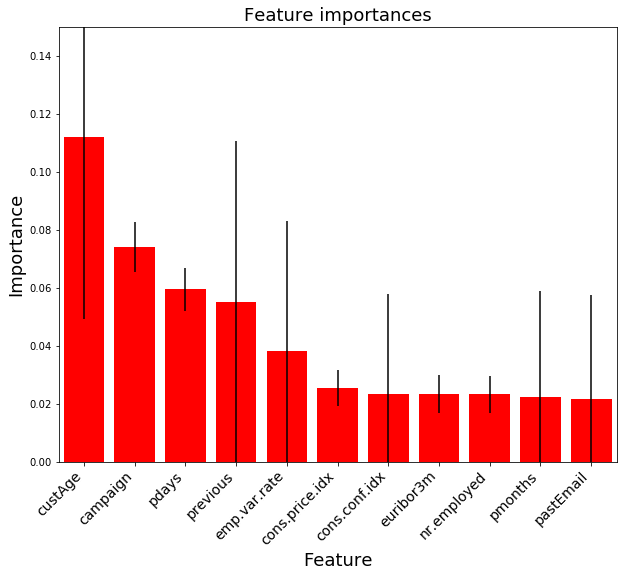

In [29]:
# Plot the feature importances of the forest
mpl_fig = plt.figure(figsize=(10, 8))
ax = mpl_fig.add_subplot(111)
# plt.figure()
ax.set_title("Feature importances", fontsize=18)
ax.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
ax.set_xticks(range(x_train.shape[1]))
ax.set_xlim([-0.5, 10.5])
ax.set_ylim([0, 0.15])
ax.set_xlabel("Feature", fontsize=18)
ax.set_ylabel("Importance", fontsize=18)
ax.set_xticklabels((feature_list), rotation=45, fontsize=14, ha = 'right')
plt.show()

## Model fitting

In [30]:
coarse_RF_search = RandomForestClassifier(n_estimators = 200, 
                                          n_jobs=-1, 
                                          class_weight='balanced_subsample')
param_grid = {'max_features':[6, 7, 8, 9],  #suggested value is sqrt(number of features, 11 here) 
       'min_samples_leaf':[2, 3, 5, 8, 11, 15]}
GS_search = GridSearchCV(estimator=coarse_RF_search, param_grid = param_grid, cv=5)
y_train=y_train.reshape(-1,)
GS_search.fit(x_train,y_train)
print "Best coarse params: %s " % GS_search.best_params_

Best coarse params: {'max_features': 6, 'min_samples_leaf': 2} 


In [39]:
fine_RF_search = RandomForestClassifier(n_estimators = 200, n_jobs=-1,
                                          class_weight='balanced_subsample')
param_grid = {'max_features':[5, 6, 7],  #suggested value is sqrt(number of features, 11 here) 
       'min_samples_leaf':[2, 3, 4]}
GS_search = GridSearchCV(estimator=fine_RF_search, param_grid = param_grid, cv=5)
y_train=y_train.reshape(-1,)
GS_search.fit(x_train,y_train)
print "Best fine params: %s " % GS_search.best_params_

Best fine params: {'max_features': 7, 'min_samples_leaf': 2} 


In [47]:
def oob_error_plot(n_estimator_begin, n_estimator_end, step = 2):
    oob_error = []
    test_error = []
    for i in xrange(n_estimator_begin, n_estimator_end, step):
        rf = RandomForestClassifier(n_estimators=i, 
                                    n_jobs=-1, 
                                    oob_score=True,
                                    max_features = 7,
                                    min_samples_leaf = 2,
                                    class_weight='balanced_subsample')
        rf.fit(x_train, y_train)
        oob_error_temp = 1 - rf.oob_score_
        test_error_temp = 1- rf.score(x_valid, y_valid)
        oob_error.append(oob_error_temp)
        test_error.append(test_error_temp)
    
    mpl_fig = plt.figure(figsize=(6, 4))
    plt.plot(range(n_estimator_begin, n_estimator_end, step), oob_error, \
           color="r")
    plt.xlabel("Number of trees")
    plt.ylabel("OOB error rate")
    plt.show()

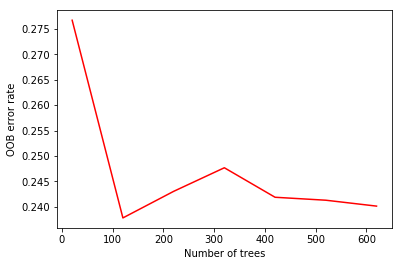

In [48]:
oob_error_plot(20,720,100)

## Conclusion: select number of trees = 500

In [49]:
RF_final = RandomForestClassifier(n_estimators = 500, 
                                  n_jobs=-1, 
                                  oob_score=True,
                                  max_features=7, 
                                  min_samples_leaf=2, 
                                  class_weight='balanced_subsample')

In [50]:
RF_final.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features=7,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [51]:
print "Accuracy score:  ", RF_final.score(x_valid, y_valid)
print "Out of bag score:", RF_final.oob_score_
y_predict = RF_final.predict(x_valid)
print 'Precision:       ', precision_score(y_valid, y_predict)
print 'Recall:          ', recall_score(y_valid, y_predict)

Accuracy score:   0.779582366589
Out of bag score: 0.761600928074
Precision:        0.736434108527
Recall:           0.608974358974


In [52]:
confu_mat = confusion_matrix(y_valid, y_predict)

In [57]:
print 'Confution Matrix'
print ' ----------------------------------'
print '|          | Pred  (1) | Pred (0) |'
print ' ----------------------------------'
print '| Act  (1) |    %d     |    %d    |' %(confu_mat[1,1], confu_mat[1, 0])
print '| Act  (0) |    %d     |    %d   |' %(confu_mat[0,1], confu_mat[0, 0])
print ' ----------------------------------'

Confution Matrix
 ----------------------------------
|          | Pred  (1) | Pred (0) |
 ----------------------------------
| Act  (1) |    95     |    61    |
| Act  (0) |    34     |    241   |
 ----------------------------------


## ROC curve

AUC 0.792843822844


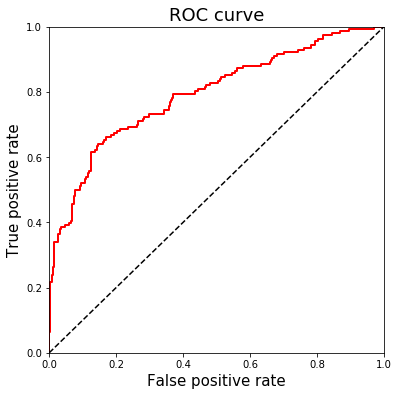

In [58]:
fpr, tpr, thresholds = roc_curve(y_valid, RF_final.predict_proba(x_valid)[:,1])
print 'AUC', auc(fpr, tpr)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(fpr, tpr, lw=2, c='r')
ax.plot([0 ,1], [0, 1], 'k--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('False positive rate', fontsize = 15)
ax.set_ylabel('True positive rate', fontsize = 15)
ax.set_title('ROC curve', fontsize = 18)
plt.show()

## AdaBoost

In [60]:
coarse_adaboost_search = AdaBoostClassifier()
param_grid = {'n_estimators':[30, 50, 100, 200, 400]}
GS_search = GridSearchCV(estimator=coarse_adaboost_search, param_grid = param_grid)
y_train=y_train.reshape(-1,)
GS_search.fit(x_train,y_train)
print "Best coarse params: %s " % GS_search.best_params_

Best coarse params: {'n_estimators': 50} 


In [61]:
fine_adaboost_search = AdaBoostClassifier(n_estimators=50)
param_grid = {'learning_rate':[0.1, 0.5, 1, 5, 10]}
GS_search = GridSearchCV(estimator=fine_adaboost_search, param_grid = param_grid)
y_train=y_train.reshape(-1,)
GS_search.fit(x_train,y_train)
print "Best coarse params: %s " % GS_search.best_params_

Best coarse params: {'learning_rate': 1} 


In [62]:
adboost = AdaBoostClassifier(n_estimators=50, learning_rate=1)
adboost.fit(x_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=50, random_state=None)

In [64]:
print "Accuracy score:  ", adboost.score(x_valid, y_valid)
y_predict = adboost.predict(x_valid)
print 'Precision:       ', precision_score(y_valid, y_predict)
print 'Recall:          ', recall_score(y_valid, y_predict)

 Accuracy score:   0.7656612529
Precision:        0.757009345794
Recall:           0.519230769231


In [65]:
confu_mat = confusion_matrix(y_valid, y_predict)
print 'Confution Matrix'
print ' ----------------------------------'
print '|          | Pred  (1) | Pred (0) |'
print ' ----------------------------------'
print '| Act  (1) |    %d     |    %d    |' %(confu_mat[1,1], confu_mat[1, 0])
print '| Act  (0) |    %d     |    %d   |' %(confu_mat[0,1], confu_mat[0, 0])
print ' ----------------------------------'

Confution Matrix
 ----------------------------------
|          | Pred  (1) | Pred (0) |
 ----------------------------------
| Act  (1) |    81     |    75    |
| Act  (0) |    26     |    249   |
 ----------------------------------


AUC 0.776783216783


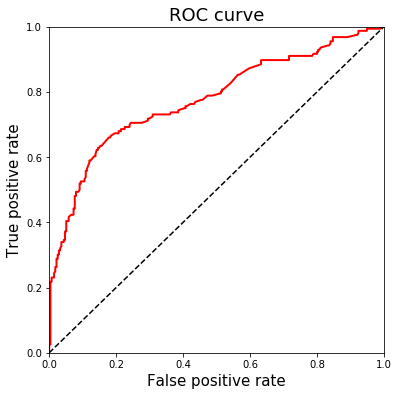

In [66]:
fpr, tpr, thresholds = roc_curve(y_valid, adboost.predict_proba(x_valid)[:,1])
print 'AUC', auc(fpr, tpr)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(fpr, tpr, lw=2, c='r')
ax.plot([0 ,1], [0, 1], 'k--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('False positive rate', fontsize = 15)
ax.set_ylabel('True positive rate', fontsize = 15)
ax.set_title('ROC curve', fontsize = 18)
plt.show()

## GradientBoost

In [32]:
coarse_grdboost_search = GradientBoostingClassifier(verbose=0)
param_grid = {'n_estimators':[30, 100, 200, 400],  
              'max_depth':[2, 5, 8],
              'subsample': [0.1, 0.4, 0.8]}
GS_search = GridSearchCV(estimator=coarse_grdboost_search, param_grid = param_grid)
y_train=y_train.reshape(-1,)
GS_search.fit(x_train,y_train)
print "Best coarse params: %s " % GS_search.best_params_

Best coarse params: {'n_estimators': 100, 'subsample': 0.8, 'max_depth': 2} 


In [67]:
fine_grdboost_search = GradientBoostingClassifier(n_estimators=100, max_depth=2)
param_grid = {'subsample': [0.7, 0.8, 0.9]}
GS_search = GridSearchCV(estimator=fine_grdboost_search, param_grid = param_grid)
y_train=y_train.reshape(-1,)
GS_search.fit(x_train,y_train)
print "Best fine params: %s " % GS_search.best_params_

Best fine params: {'subsample': 0.8} 


In [68]:
grdboost = GradientBoostingClassifier(n_estimators=100, max_depth=2, subsample=0.8) 

In [69]:
grdboost.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=0.8, verbose=0, warm_start=False)

In [70]:
print "Accuracy score:  ", grdboost.score(x_valid, y_valid)
y_predict = grdboost.predict(x_valid)
print 'Precision:       ', precision_score(y_valid, y_predict)
print 'Recall:          ', recall_score(y_valid, y_predict)

Accuracy score:   0.772621809745
Precision:        0.745762711864
Recall:           0.564102564103


AUC 0.795675990676


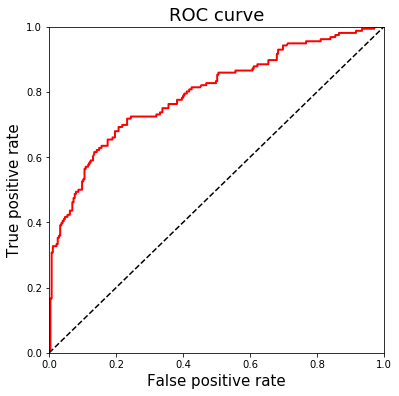

In [71]:
fpr, tpr, thresholds = roc_curve(y_valid, grdboost.predict_proba(x_valid)[:,1])
print 'AUC', auc(fpr, tpr)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(fpr, tpr, lw=2, c='r')
ax.plot([0 ,1], [0, 1], 'k--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('False positive rate', fontsize = 15)
ax.set_ylabel('True positive rate', fontsize = 15)
ax.set_title('ROC curve', fontsize = 18)
plt.show()

## XGBoost

In [33]:
coarse_xgbst_search = xgb.XGBClassifier( learning_rate =0.01,                                                                                  
                                         min_child_weight=6,
                                         gamma=0,
                                         objective= 'binary:logistic',
                                         nthread=4,
                                         scale_pos_weight=1)
param_grid = {'n_estimators':[100, 300, 500],  
              'max_depth':[2, 5, 7],
              'subsample': [0.7, 0.8, 0.9],
              'colsample_bytree':[0.7, 0.8, 0.9],
              'reg_alpha':[0.001, 0.005, 0.01]}
GS_search = GridSearchCV(estimator=coarse_xgbst_search, param_grid = param_grid)
y_train=y_train.reshape(-1,)
GS_search.fit(x_train,y_train)
print "Best coarse params: %s " % GS_search.best_params_

/Users/miyan/xgboost/python-package/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/miyan/xgboost/python-package/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/miyan/xgboost/python-package/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/miyan/xgboost/python-package/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/miyan/xgboost/python-package/xgboost/sklearn.py:171: DeprecationWarning: 

Best coarse params: {'n_estimators': 500, 'subsample': 0.9, 'reg_alpha': 0.001, 'colsample_bytree': 0.7, 'max_depth': 2} 


In [42]:
fine_xgbst_search = xgb.XGBClassifier(learning_rate =0.01,                                                                                  
                                         min_child_weight=6,
                                         gamma=0,
                                         objective= 'binary:logistic',
                                         nthread=4,
                                         scale_pos_weight=1)
param_grid = {'n_estimators':[400, 500, 600],  
              'max_depth':[2, 3, 4],
              'subsample': [0.7, 0.8, 0.9],
              'colsample_bytree':[0.6, 0.7, 0.8],
              'reg_alpha':[0.0005, 0.001, 0.003]}
GS_search = GridSearchCV(estimator=fine_xgbst_search, param_grid = param_grid)
y_train=y_train.reshape(-1,)
GS_search.fit(x_train,y_train)
print "Best coarse params: %s " % GS_search.best_params_

/Users/miyan/xgboost/python-package/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/miyan/xgboost/python-package/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/miyan/xgboost/python-package/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/miyan/xgboost/python-package/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
/Users/miyan/xgboost/python-package/xgboost/sklearn.py:171: DeprecationWarning: 

Best coarse params: {'n_estimators': 500, 'subsample': 0.9, 'reg_alpha': 0.0005, 'colsample_bytree': 0.7, 'max_depth': 2} 


In [72]:
xgbst = xgb.XGBClassifier(learning_rate =0.01,
                         n_estimators=500,
                         max_depth=2,
                         min_child_weight=6,
                         gamma=0,
                         subsample=0.9,
                         colsample_bytree=0.7,
                         reg_alpha=0.0005,
                         objective= 'binary:logistic',
                         nthread=4,
                         scale_pos_weight=1)
xgbst.fit(x_train,y_train)

/Users/miyan/xgboost/python-package/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=6, missing=None, n_estimators=500,
       n_jobs=4, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0.0005, reg_lambda=1, scale_pos_weight=1, seed=0,
       silent=True, subsample=0.9)

In [73]:
print "Accuracy score:  ", xgbst.score(x_valid, y_valid)
y_predict = xgbst.predict(x_valid)
print 'Precision:       ', precision_score(y_valid, y_predict)
print 'Recall:          ', recall_score(y_valid, y_predict)

Accuracy score:   0.77030162413
Precision:        0.766355140187
Recall:           0.525641025641


AUC 0.799440559441


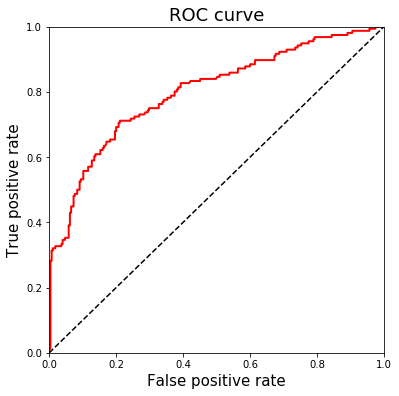

In [74]:
fpr, tpr, thresholds = roc_curve(y_valid, xgbst.predict_proba(x_valid)[:,1])
print 'AUC', auc(fpr, tpr)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(fpr, tpr, lw=2, c='r')
ax.plot([0 ,1], [0, 1], 'k--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('False positive rate', fontsize = 15)
ax.set_ylabel('True positive rate', fontsize = 15)
ax.set_title('ROC curve', fontsize = 18)
plt.show()

In [77]:
1 - len(y_valid[y_valid == 1])/float(len(y_valid))

0.6380510440835268

# Predict output of test data

## Preprocessing

In [78]:
df_raw_test.replace('unknown', np.NaN, inplace=True)

In [80]:
custAge_fillna(df_raw_test)

In [81]:
df_raw_test = apply_fillna_based_on_ratio_dummy(df_raw_test, missing_category_feature_list, keep_element_ratio)

In [82]:
df_raw_test = apply_add_dummy(df_raw_test, normal_category_feature_list)

In [125]:
df = df_backup.copy()
df.pop('responded')
df_raw_test1 = df_raw_test.iloc[:,1:]
train_features = df.columns 
test_features = df_raw_test1.columns
x_test = df_raw_test1.values

In [126]:
for i, element in enumerate(train_features):
    if element not in test_features:
        x_test = np.insert(x_test, i, 0, axis=1)       
        print i, element

29 schooling_illiterate
33 default_yes


In [83]:
check_null(df_raw_test)

The null ratio in PERCENTAGE (%):
Unnamed: 0                       0.0
custAge                          0.0
campaign                         0.0
pdays                            0.0
previous                         0.0
emp.var.rate                     0.0
cons.price.idx                   0.0
cons.conf.idx                    0.0
euribor3m                        0.0
nr.employed                      0.0
pmonths                          0.0
pastEmail                        0.0
profession_admin.                0.0
profession_blue-collar           0.0
profession_entrepreneur          0.0
profession_housemaid             0.0
profession_management            0.0
profession_retired               0.0
profession_self-employed         0.0
profession_services              0.0
profession_student               0.0
profession_technician            0.0
profession_unemployed            0.0
marital_divorced                 0.0
marital_married                  0.0
marital_single                   0.0
scho

## Apply XGBoost to Raw test data

In [128]:
y_test = xgbst.predict(x_test)

In [131]:
y_test2 = ['yes' if i == 1 else 'no' for i in y_test]

In [134]:
df_raw_test_new = pd.read_csv('marketing_test.csv')

In [135]:
df_raw_test_new['responded'] = y_test2

In [138]:
df_raw_test_new.to_csv("test_predict.csv")